In [5]:
import json
import pandas as pd
from tqdm import tqdm
from collections import Counter
from unidecode import unidecode
from flair.data import Sentence
from flair.models import SequenceTagger
from flair.models import TextClassifier
from rich import print

import seaborn as sns
from matplotlib.colors import TwoSlopeNorm
import matplotlib.pyplot as plt

%matplotlib inline

def extract_names(docs, save=False):
    results = []
    
    for doc in tqdm(docs):
        
        # split doc in sentences
        sentences = [e + "." for e in doc.split(".") if e]
        
        for sent in sentences:
            
            sentence = Sentence(sent, use_tokenizer=True)
            tagger.predict(sentence)

            for entity in sentence.get_spans('ner'):
                
                # Extract person and predict sentiment if person is in sentence
                if entity.tag == "PER":
                    classifier.predict(sentence)
                    score = sentence.get_labels()[0].score
                    value = sentence.get_labels()[0].value
                    name = entity.text
                    results.append((name, score, value))

    if save:
        with open(f'../data/{save}_names.json', 'w') as f:
            json.dump(results, f)
                
    return results

**Load Model**  
This model was trained over the English CoNLL-03 task and can recognize 4 different entity types.

In [4]:
tagger = SequenceTagger.load('ner-fast')  # ner-fast for cpu-based predictions
classifier = TextClassifier.load('sentiment-fast')

2020-08-10 16:03:18,003 loading file /home/CORP.VANSPAENDONCKGROEP.NL/maarten.grootendorst/.flair/models/en-ner-fast-conll03-v0.4.pt
2020-08-10 16:03:19,715 loading file /home/CORP.VANSPAENDONCKGROEP.NL/maarten.grootendorst/.flair/models/sentiment-en-mix-ft-rnn.pt


**Load Data**

In [6]:
with open('../data/pixar_reviews.json') as f:
    reviews = json.load(f)

movie = reviews['Toy Story']
df = pd.DataFrame(movie, columns=["Title", "Review"])
docs = list(df.Review.values)

**Generate Predictions**

In [7]:
names = extract_names(docs, save="toy_story") 

100%|██████████| 602/602 [03:51<00:00,  2.60it/s]


**Visualize Results**  

Fix: 
* Miguel's
* ,Miguel
* Tom Hanks


In [86]:
def extract_df(name_list):
    df = pd.DataFrame(name_list, columns=["Word", "Prob", "Sentiment"])
    df.Sentiment = df.Sentiment.map({"POSITIVE": 1, "NEGATIVE": -1})
    df.Word = df.Word.astype(str)
    df = preprocess_counts(df)
    return df

In [102]:
def preprocess_counts(df):
    """ Preprocess the data
    
    * Combine names such as Miguel and Miguel's by removing everything next to the special character 
    
    """
    # Remove accents
    df.Word = [unidecode(word) for word in df.Word]
    
    # Combine names such as Miguel and Miguel's by removing everything next to the special character
#     df.Word = df.Word.str.replace('[^A-z]',' ').str.strip().str.split(' ').str[0]  
    df.Word = df.Word.str.replace('[^A-z]',' ').str.strip()
    df = df.groupby("Word").agg({"Sentiment": [np.mean, np.count_nonzero]})
    df.columns = df.columns.droplevel()
    df = df.reset_index()
    df.columns = ["Word", "Sentiment", "Count"]
    df = df.sort_values("Count", ascending=False)
    
    # Remove names less than 3 characters
    df = df.loc[df.Word.str.len() >= 3, :]
    
    # Remove the "name" Disney
    df = df.loc[df.Word != "Disney", :]
    
    return df

In [147]:
toy = extract_df(names)

In [156]:
def transform_sentiment(row):
    return round((1 - row * 2) * -1, 3)
toy["Sentiment_Transformed"] = toy.apply(lambda row: transform_sentiment(row.Sentiment), 1)

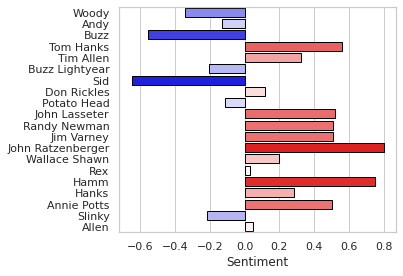

In [166]:
norm = TwoSlopeNorm(vmin=toy.Sentiment_Transformed.head(20).min(), vcenter=0.0, vmax=toy.Sentiment_Transformed.head(20).max())
colors = [plt.cm.bwr(norm(c)) for c in toy.Sentiment_Transformed.head(20)]
ax = sns.barplot(x='Sentiment_Transformed', y='Word', data=toy.head(20), palette=colors, edgecolor='black')
plt.tight_layout()
plt.xlabel("Sentiment")
plt.ylabel("")
plt.show()
# plt.savefig("../data/toy_story.png", dpi=300)

In [92]:
# results.to_csv("../data/toy_story_names.csv", index=False)